# Osman Tarihi Araştırmalarında Yapay Zeka: İstanbul Kadı Sicillerine Derinlemesine Bakış

In [2]:
pip install -r requirements.txt

In [3]:
import pandas as pd
from scripts.ner_automation import *
from utils.openai_client import client

In [ ]:
file_path = 'data/raw.csv'
df = pd.read_csv(file_path)
df['case_text_summary'] = "Summary: " + df['case_summary'].astype(str) + "\n" + "Case: " + df['case_text'].astype(str)

In [4]:
df.head()

,Unnamed: 0,court_title,sicil_number,sicil_date,date_hijri,date_miladi,case_text,case_summary,case_number,id,case_text_summary
0,0,Adalar,1,H. 1178-1184 / M. 1764-1771,H. 1178-1184,M. 1764-1771,"['[İç Kapak]', 'Mûcebince amel oluna deyü buyr...",117[8] ilâ 1184 Adalar Hücec,Hüküm no:,1,Summary: 117[8] ilâ 1184 Adalar Hücec\nCase: [...
1,1,Adalar,1,H. 1178-1184 / M. 1764-1771,H. 1178-1184,M. 1764-1771,['Kasab Veli Beşe kanadârı Mumço? nâm zimmîye ...,Kasap Veli’nin Mumço’ya kefil olduğu,Hüküm no: 1,2,Summary: Kasap Veli’nin Mumço’ya kefil olduğu\...
2,2,Adalar,1,H. 1178-1184 / M. 1764-1771,H. 1178-1184,M. 1764-1771,['Bundan akdem hâlik olan Esteban v. Kirkor v....,Ölen Esteban’ın terekesinin varislerine taksim...,Hüküm no: 2,3,Summary: Ölen Esteban’ın terekesinin varisleri...
3,3,Adalar,1,H. 1178-1184 / M. 1764-1771,H. 1178-1184,M. 1764-1771,['Culûs-ı Sultân Mustafa Han b. es-Sultân Abdü...,Sultan Mustafa Han’ın tahta çıkış tarihinin no...,Hüküm no: 3,4,Summary: Sultan Mustafa Han’ın tahta çıkış tar...
4,4,Adalar,1,H. 1178-1184 / M. 1764-1771,H. 1178-1184,M. 1764-1771,['Devletlü inâyetlü merhametlü efendim sultânı...,Yarım kalan bir arzuhal kaydı,Hüküm no: 4,5,Summary: Yarım kalan bir arzuhal kaydı\nCase: ...


İsam Veri Tabanından çekilen verilerin kısaca değerlendirilmesi

In [15]:
# Farklı mahkeme sayısı
num_courts = df['court_title'].nunique()

# Her mahkeme için sicil sayısı (court_title ve sicil_number birleştirilerek)
registers_per_court = df.groupby('court_title')['sicil_number'].nunique()

# Her mahkeme için dava girişlerinin sayısı
case_entries_per_court = df.groupby('court_title').size()

# Toplam dava sayısı
total_cases = case_entries_per_court.sum()

# Sonuçları göster
print(f"Farklı mahkeme sayısı: {num_courts}")
print("Her mahkeme için sicil sayısı:")
print(registers_per_court)
print("Her mahkeme için dava girişlerinin sayısı:")
print(case_entries_per_court)
print(f"Toplam dava sayısı: {total_cases}")
total_registers = registers_per_court.sum()
print(f"Toplam sicil sayısı: {total_registers}")



Farklı mahkeme sayısı: 22
Her mahkeme için sicil sayısı:
court_title
Adalar                 1
Ahi Çelebi             1
Anadolu Sadareti       1
Anadolu Sadâreti       1
Bab                   10
Balat                  2
Beşiktaş               2
Davud Paşa             1
Evkaf Mahkemesi        1
Evkaf Muhasebesi       1
Evkaf Müfettişliği     1
Eyüp                  11
Galata                12
Hasköy                 3
Kartal                 1
Kısmet-i Askeriye      2
Mahfel-i Şer‘iyyât     1
Mahmudpaşa             1
Rumeli Sadareti        8
Tophane                1
Üsküdar               13
İstanbul              24
Name: sicil_number, dtype: int64
Her mahkeme için dava girişlerinin sayısı:
court_title
Adalar                  183
Ahi Çelebi              534
Anadolu Sadareti        185
Anadolu Sadâreti        254
Bab                    7245
Balat                  1115
Beşiktaş               1027
Davud Paşa              788
Evkaf Mahkemesi         239
Evkaf Muhasebesi         82
Evkaf Müfetti

Görüldüğü gibi mahkeme isimleri arasında bir takım tutarsızlıklar mevcüt. Alttaki kod bu tutarsızlıkları düzeltmek için.

In [14]:
# Perform the specified changes in the DataFrame
df.loc[df['court_title'] == 'Evkaf Muhasebesi1', 'court_title'] = 'Evkaf Muhasebesi'
df.loc[df['court_title'] == 'Eyüb', 'court_title'] = 'Eyüp'
df.loc[df['court_title'] == 'Rumeli Sadâreti', 'court_title'] = 'Rumeli Sadareti'
df.loc[df['court_title'] == 'Evkaf-ı Hümâyûn', 'court_title'] = 'Evkaf Mahkemesi'
df.loc[df['court_title'] == 'Evkaf-ı HümâyûnMüfettişliği', 'court_title'] = 'Evkaf Müfettişliği'

df.loc[df['court_title'] == 'Evkaf Müfettişliği', 'sicil_number'] = '1'
df.loc[df['court_title'] == 'Evkaf Muhasebesi', 'sicil_number'] = '1'
df.loc[df['court_title'] == 'Evkaf Mahkemesi', 'sicil_number'] = '673'

In [17]:
most_cases = df.loc[df['court_title'] == case_entries_per_court.idxmax(), ['court_title', 'sicil_number']].iloc[0]
least_cases = df.loc[df['court_title'] == case_entries_per_court.idxmin(), ['court_title', 'sicil_number']].iloc[0]

print(f"En fazla dava sayısı olan defter: {most_cases['court_title']} sicil numarası {most_cases['sicil_number']} ({case_entries_per_court.max()} dava)")
print(f"En az dava sayısı olan defter: {least_cases['court_title']} sicil numarası {least_cases['sicil_number']} ({case_entries_per_court.min()} dava)")

En fazla dava sayısı olan defter: İstanbul sicil numarası 3 (12348 dava)
En az dava sayısı olan defter: Evkaf Muhasebesi sicil numarası 1 (82 dava)


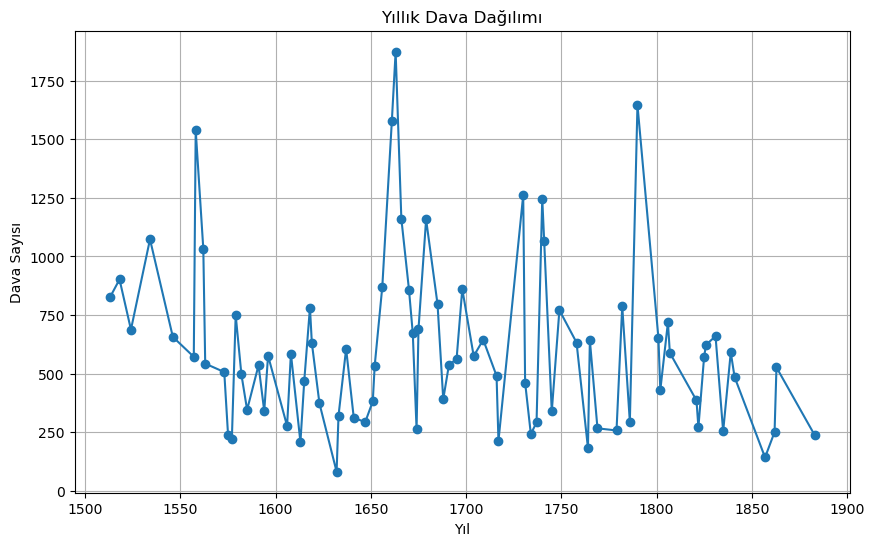

In [19]:
import matplotlib.pyplot as plt

# date_miladi sütununu düzenleyin ve sadece yılı alın
df['year'] = df['date_miladi'].str.extract(r'M\. (\d{4})').astype(float)

# NaN değerlerini kaldırın
df = df.dropna(subset=['year'])

# Yıllık bazda dava sayısını hesaplayın
yearly_case_counts = df['year'].value_counts().sort_index()

# Yıllık dava dağılımını gösteren bir grafik oluşturun
plt.figure(figsize=(10, 6))
plt.plot(yearly_case_counts.index, yearly_case_counts.values, marker='o', linestyle='-')
plt.title('Yıllık Dava Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Dava Sayısı')
plt.grid(True)
plt.show()

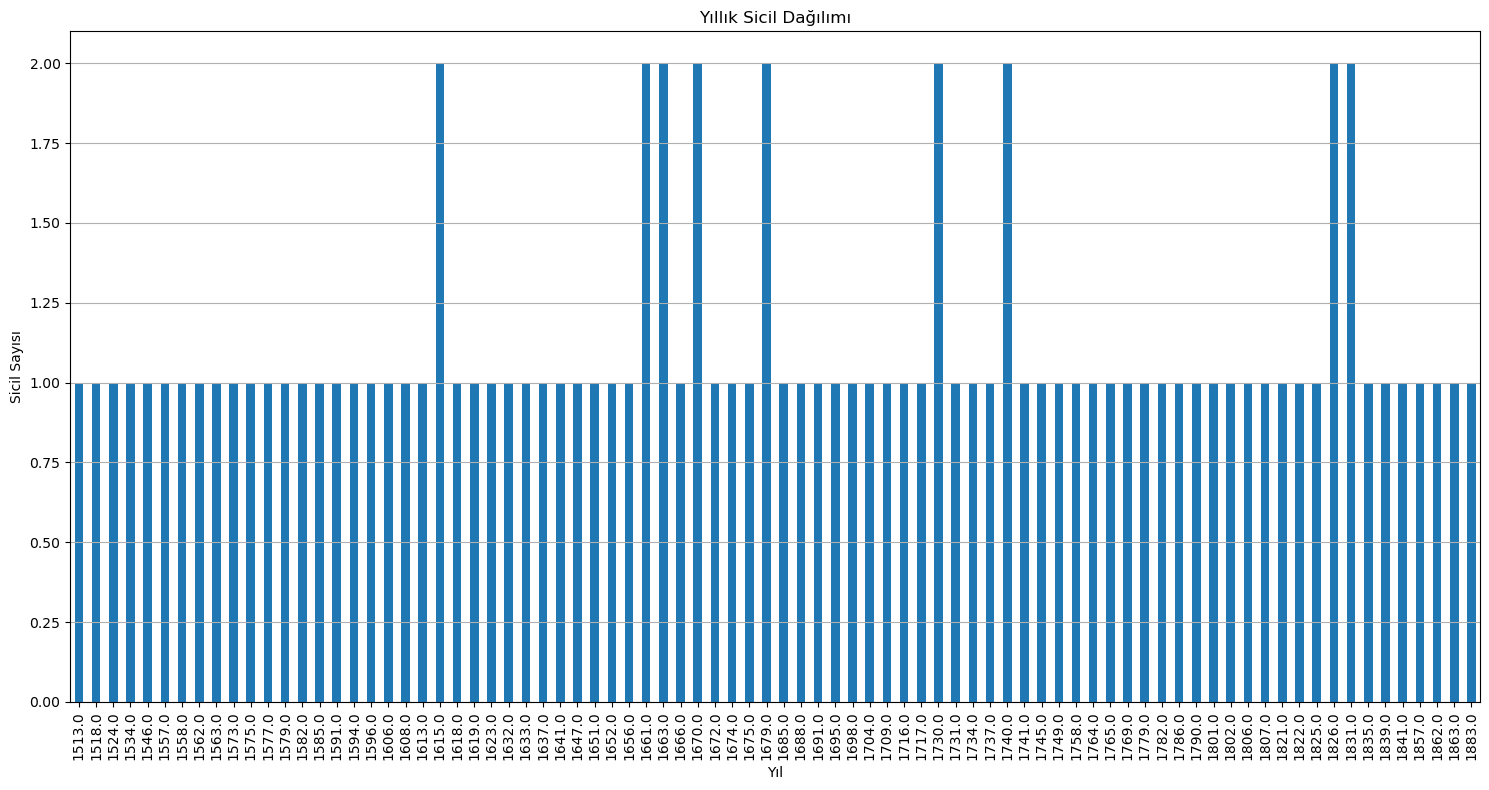

In [25]:
# date_miladi sütununu düzenleyin ve sadece yılı alın
df['year'] = df['date_miladi'].str.extract(r'M\. (\d{4})').astype(float)

# NaN değerlerini kaldırın
df = df.dropna(subset=['year'])

# Yıllık bazda toplam sicil sayısını hesaplayın
yearly_register_counts = df.groupby('year')['sicil_number'].nunique()

# Yıllık sicil dağılımını gösteren bir sütun grafiği oluşturun
plt.figure(figsize=(15, 8))
yearly_register_counts.plot(kind='bar')
plt.title('Yıllık Sicil Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Sicil Sayısı')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

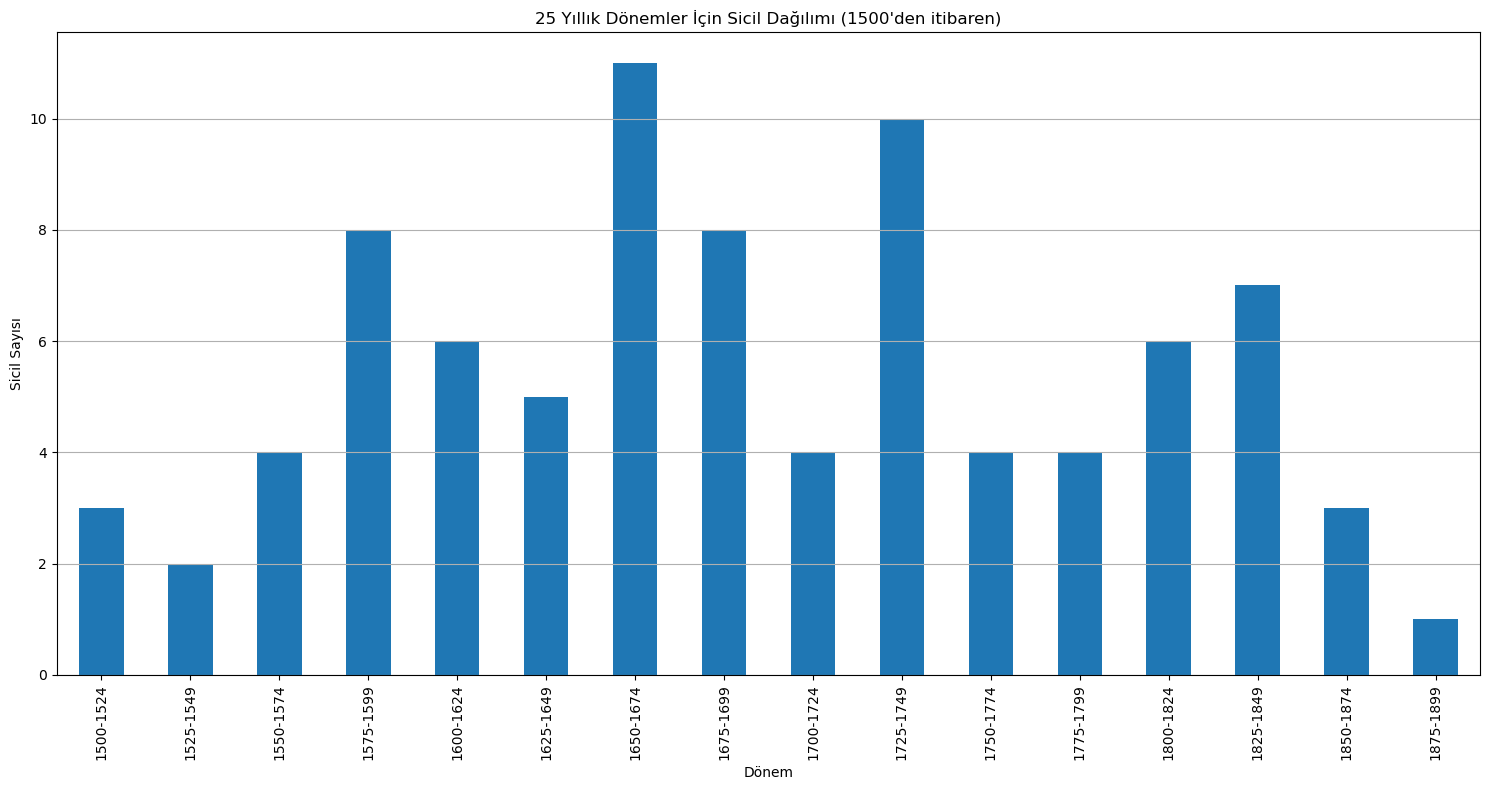

In [28]:
# date_miladi sütununu düzenleyin ve sadece yılı alın
df['year'] = df['date_miladi'].str.extract(r'M\. (\d{4})').astype(float)

# NaN değerlerini kaldırın
df = df.dropna(subset=['year'])

# Yılları 1500'den itibaren 25 yıllık aralıklara ayırın
bins = range(1500, int(df['year'].max()) + 25, 25)
labels = [f"{start}-{start+24}" for start in bins[:-1]]
df['period'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)

# 25 yıllık dönemler için toplam sicil sayısını hesaplayın
periodic_register_counts = df.groupby('period')['sicil_number'].nunique()

# 25 yıllık dönemlerin sicil dağılımını gösteren bir sütun grafiği oluşturun
plt.figure(figsize=(15, 8))
periodic_register_counts.plot(kind='bar')
plt.title('25 Yıllık Dönemler İçin Sicil Dağılımı (1500\'den itibaren)')
plt.xlabel('Dönem')
plt.ylabel('Sicil Sayısı')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

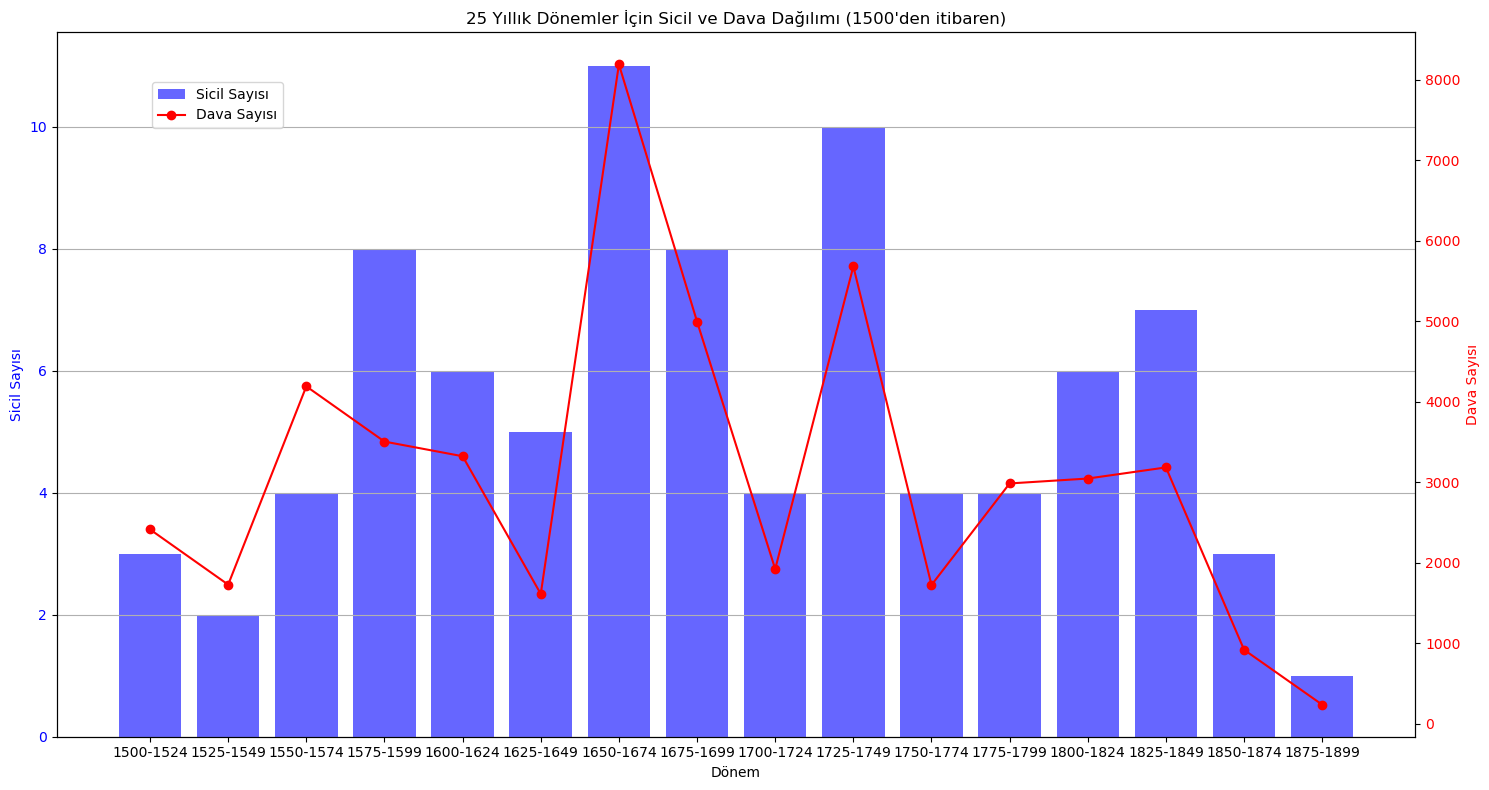

In [29]:
# date_miladi sütununu düzenleyin ve sadece yılı alın
df['year'] = df['date_miladi'].str.extract(r'M\. (\d{4})').astype(float)

# NaN değerlerini kaldırın
df = df.dropna(subset=['year'])

# Yılları 1500'den itibaren 25 yıllık aralıklara ayırın
bins = range(1500, int(df['year'].max()) + 25, 25)
labels = [f"{start}-{start+24}" for start in bins[:-1]]
df['period'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)

# 25 yıllık dönemler için toplam sicil sayısını hesaplayın
periodic_register_counts = df.groupby('period')['sicil_number'].nunique()

# 25 yıllık dönemler için toplam dava sayısını hesaplayın
periodic_case_counts = df['period'].value_counts().sort_index()

# 25 yıllık dönemlerin sicil ve dava dağılımını gösteren bir sütun grafiği oluşturun
fig, ax1 = plt.subplots(figsize=(15, 8))

# Sicil sayılarını bar grafiği olarak göster
ax1.bar(periodic_register_counts.index, periodic_register_counts.values, color='b', alpha=0.6, label='Sicil Sayısı')
ax1.set_xlabel('Dönem')
ax1.set_ylabel('Sicil Sayısı', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Aynı grafikte dava sayılarını da göstermek için ikinci bir y ekseni oluştur
ax2 = ax1.twinx()
ax2.plot(periodic_case_counts.index, periodic_case_counts.values, color='r', marker='o', linestyle='-', label='Dava Sayısı')
ax2.set_ylabel('Dava Sayısı', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Başlık ve grid ekle
plt.title('25 Yıllık Dönemler İçin Sicil ve Dava Dağılımı (1500\'den itibaren)')
ax1.grid(axis='y')

# Grafik üzerine legend ekle
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

plt.tight_layout()
plt.show()

Görüldüğü üzere en fazla defterin ve kaydın bulunduğu aralık 1650-75 tarihleri arası. GPT destekli analizim için bu tarih aralığından bir defter örneği seçmek istiyorum.

In [30]:
# Filter the dataframe for the period 1650-1675
df_filtered = df[(df['year'] >= 1650) & (df['year'] < 1676)]

# Select unique court titles and their sicil numbers within this period
registers_1650_1675 = df_filtered[['court_title', 'sicil_number']].drop_duplicates().reset_index(drop=True)

In [31]:
registers_1650_1675

,court_title,sicil_number
0,Ahi Çelebi,1
1,Bab,3
2,Bab,11
3,Beşiktaş,63
4,Eyüp,7
5,Eyüp,8
6,Galata,90
7,Galata,114
8,Hasköy,10
9,İstanbul,10


In [36]:
# Filter the dataframe for the specified court and sicil number
istanbul_10_cases = df[(df['court_title'] == 'İstanbul') & (df['sicil_number'] == '10')]

# Count the total number of case entries in this register
total_cases_istanbul_10 = istanbul_10_cases.shape[0]

total_cases_istanbul_10
print(f"İstanbul 10 numaralı defterdeki toplam dava kaydı: {total_cases_istanbul_10}")

İstanbul 10 numaralı defterdeki toplam dava kaydı: 1123


## court_sicil_list = [
    ('Ahi Çelebi', '1'),
    ('Bab', '3'),
    ('Bab', '11'),
    ('Beşiktaş', '63'),
    ('Eyüp', '7'),
    ('Eyüp', '8'),
    ('Galata', '90'),
    ('Galata', '114'),
    ('Hasköy', '10'),
    ('İstanbul', '10'),
    ('İstanbul', '12'),
    ('İstanbul', '18'),
    ('Rumeli Sadareti', '106')
]

# Filtrelenmiş veriyi oluşturun
filtered_df = df[df.apply(lambda x: (x['court_title'], x['sicil_number']) in court_sicil_list, axis=1)]

# Her mahkeme ve sicil numarası için dava sayılarını hesaplayın
case_counts = filtered_df.groupby(['court_title', 'sicil_number']).size().reset_index(name='case_count')

# Mahkeme ve sicil numaralarını birleştirerek etiketler oluşturun
case_counts['label'] = case_counts['court_title'] + ' ' + case_counts['sicil_number']

# Ortalama dava sayısını hesaplayın
average_case_count = case_counts['case_count'].mean()

# Grafik oluşturun
plt.figure(figsize=(15, 8))
plt.bar(case_counts['label'], case_counts['case_count'], color='b', alpha=0.6, label='Dava Sayısı')
plt.axhline(y=average_case_count, color='r', linestyle='--', label=f'Ortalama Dava Sayısı: {average_case_count:.2f}')
plt.xlabel('Mahkeme ve Sicil Numarası')
plt.ylabel('Dava Sayısı')
plt.title('Mahkeme ve Sicil Numaralarına Göre Dava Sayıları')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.legend()

plt.show()

İstanbul 18 numaralı defter en uygunu gözüküyor. Şimdi bu defter üzerinden örneklem olarak bir Named Entity Recognition (NER) görevi gerçekleştireceğiz.

In [5]:
df_copy = df.copy()
df_copy['case_id'] = (df_copy['court_title'] + '_' + 
                      df_copy['sicil_number'].astype(str) + '_' + 
                      df_copy['case_number']).str.lower()

In [8]:
# İstanbul 18 sicil defteri için veri süzme
istanbul_18_df = df_copy[(df_copy['court_title'] == 'İstanbul') & (df_copy['sicil_number'] == '18')]

# NER görevini gerçekleştirmek ve sonuçları bir dosyaya kaydetmek için dosya yolu belirleme
output_file = 'ner_results_istanbul18.csv'

# NER fonksiyonunu çağırma
process_dataframe_ner(istanbul_18_df, 'case_text_summary', 'court_title', 'case_id', output_file)

An error occured: '[' was never closed (<string>, line 427)
Error processing row 27135: '[' was never closed (<string>, line 427)
An error occured: unterminated string literal (detected at line 487) (<string>, line 487)
Error processing row 27229: unterminated string literal (detected at line 487) (<string>, line 487)
An error occured: unterminated string literal (detected at line 482) (<string>, line 482)
Error processing row 27230: unterminated string literal (detected at line 482) (<string>, line 482)


,person_id,name,gender,religion_ethnicity,social_status_job,role_in_case,titles,row_index,case_unique_id,date,calendar,place_name,place_type,legal_case_type,case_result,case_result_type
0,İstanbul_i̇stanbul_18_hüküm no: kapa_1,Beyâzîzâde Efendi,Man,Muslim,N/A,Deceased,[Efendi],27133,i̇stanbul_18_hüküm no: kapa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27133,i̇stanbul_18_hüküm no: kapa,1086,Hijri,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27133,i̇stanbul_18_hüküm no: kapa,1087,Hijri,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27133,i̇stanbul_18_hüküm no: kapa,1675,Miladi,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27133,i̇stanbul_18_hüküm no: kapa,1676,Miladi,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27822,i̇stanbul_18_hüküm no: 689,N/A,Miladi,NaN,NaN,NaN,NaN,NaN
13748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27822,i̇stanbul_18_hüküm no: 689,NaN,NaN,İstanbul,city,NaN,NaN,NaN
13749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27822,i̇stanbul_18_hüküm no: 689,NaN,NaN,NaN,NaN,Property Disputes,NaN,NaN
13750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27822,i̇stanbul_18_hüküm no: 689,NaN,NaN,NaN,NaN,NaN,N/A,NaN


In [7]:
ner_df

,person_id,name,gender,religion_ethnicity,social_status_job,role_in_case,titles,row_index,case_unique_id,date,calendar,place_name,place_type,legal_case_type,case_result,case_result_type
0,İstanbul_i̇stanbul_18_hüküm no: 6_1,Süleyman b. Kör Ali Ağa,Man,Muslim,N/A,Plaintiff,[],27139,i̇stanbul_18_hüküm no: 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,İstanbul_i̇stanbul_18_hüküm no: 6_2,Kör Ali Ağa,Man,Muslim,N/A,Deceased Father,[Ağa],27139,i̇stanbul_18_hüküm no: 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,İstanbul_i̇stanbul_18_hüküm no: 6_3,Hüseyin Ağa b. Receb,Man,Muslim,Janissary Beytülmâlcisi,Defendant,[Ağa],27139,i̇stanbul_18_hüküm no: 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,İstanbul_i̇stanbul_18_hüküm no: 6_4,Hasan Beşe b. Mehmed,Man,Muslim,N/A,Guardian of Süleyman,[Beşe],27139,i̇stanbul_18_hüküm no: 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,İstanbul_i̇stanbul_18_hüküm no: 6_5,Kalender b. Mehmed Çelebi,Man,Muslim,N/A,Former Guardian of Süleyman,[Çelebi],27139,i̇stanbul_18_hüküm no: 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27140,i̇stanbul_18_hüküm no: 7,NaN,NaN,Şehremini,region,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27140,i̇stanbul_18_hüküm no: 7,NaN,NaN,Mustafa Çavuş mescid-i şerîfi,mosque,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27140,i̇stanbul_18_hüküm no: 7,NaN,NaN,NaN,NaN,Religious Endowments (Waqf),NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27140,i̇stanbul_18_hüküm no: 7,NaN,NaN,NaN,NaN,NaN,Ali Çelebi is ordered to pay 351 guruş to the ...,NaN


In [10]:
istanbul18 = pd.read_csv('ner_results_istanbul18.csv')

In [13]:
istanbul18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13752 entries, 0 to 13751
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   person_id           8113 non-null   object
 1   name                8113 non-null   object
 2   gender              8112 non-null   object
 3   religion_ethnicity  8092 non-null   object
 4   social_status_job   1348 non-null   object
 5   role_in_case        7941 non-null   object
 6   titles              8113 non-null   object
 7   date                1418 non-null   object
 8   calendar            1434 non-null   object
 9   place_name          2143 non-null   object
 10  place_type          2130 non-null   object
 11  legal_case_type     685 non-null    object
 12  case_result         644 non-null    object
 13  case_result_type    644 non-null    object
 14  row_index           13752 non-null  int64 
 15  case_unique_id      13752 non-null  object
dtypes: int64(1), object(15

In [55]:
# Temel istatistikleri görüntüleyin
istanbul18.describe(include='all')
istanbul18.iloc[100:101]

,person_id,name,gender,religion_ethnicity,social_status_job,role_in_case,titles,date,calendar,place_name,place_type,legal_case_type,case_result,case_result_type,row_index,case_unique_id
100,İstanbul_i̇stanbul_18_hüküm no: 6_7,Mevlânâ Mustafa Efendi b. Abdülaziz,Man,Muslim,NaN,Investigator,"['Mevlânâ', 'Efendi']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6


### Cinsiyet

In [17]:
istanbul18['gender'].value_counts()

gender
Man      7381
Woman     731
Name: count, dtype: int64

### Din

In [18]:
istanbul18['religion_ethnicity'].value_counts()

religion_ethnicity
Muslim                         7571
Greek                           247
Armenian                        139
Christian                        46
Jewish                           30
Russian                          26
European                         13
Non-Muslim                       12
European (Hungarian)              2
Circassian                        1
Habeş (Abyssinian)                1
Muslim (originally Russian)       1
Coptic                            1
Hungarian                         1
Muslim, Georgian                  1
Name: count, dtype: int64

### Dava

In [19]:
istanbul18['legal_case_type'].value_counts()

legal_case_type
Debt/Loan Agreements            193
Property Disputes               176
Marital Disputes                109
Inheritance Cases                89
Slavery and Manumission          48
Religious Endowments (Waqf)      19
Trade Disputes                   16
Criminal Cases                   14
Appointments                      5
Taxation Disputes                 4
Guardianship Appointment          3
Employment Disputes               2
Pilgrimage Arrangements           2
Adoption                          2
Contract Disputes                 1
Appointment                       1
Guardianship and Maintenance      1
Name: count, dtype: int64

In [33]:
# Sosyal durum/iş rolleri dağılımı
social_status_counts = istanbul18['social_status_job'].value_counts()
# Çıktıda görüntülenebilecek maksimum satır sayısını artırın
pd.set_option('display.max_rows', None)

# Sosyal sınıfsal kategorileri ve dağılımlarını yeniden görüntüleyin
print(social_status_counts)


social_status_job
Bureaucrat                                      313
Scholar/Ulama                                   201
Trader/Merchant                                 197
Artisan/Craftsperson                            119
Müezzin                                         111
Imam                                             82
Janissary                                        64
Slave/Enslaved Person                            56
Religious Leader                                 36
Sufi                                             11
Kethüdâ                                          10
Barber                                            9
Pilgrim                                           7
İmam                                              7
Physician/Healer                                  6
Sipahi                                            6
Treasurer                                         6
İmâm                                              6
Kayyım                                        

In [22]:
# Dava sonuçları dağılımı
case_result_counts = istanbul18['case_result'].value_counts()
case_result_counts


case_result
Settlement                                                                         92
Plaintiff won                                                                      31
Divorce granted                                                                    10
Sale completed                                                                      6
Plaintiffs won                                                                      5
                                                                                   ..
Emine bt. İbrahim acknowledged her debt and agreed to pay the remaining amount.     1
Settlement in favor of Ayşe and Kâmile                                              1
Nazar v. Parsık won the case                                                        1
Settlement in favor of Ayşe bt. Musa                                                1
Hasan Odabaşı b. Hüseyin won the case                                               1
Name: count, Length: 484, dtype: int64

In [23]:
# Dava sonuç türleri dağılımı
case_result_type_counts = istanbul18['case_result_type'].value_counts()
case_result_type_counts

case_result_type
Settlement                   460
Trial by evidence            101
Resolution by oath            63
trial by evidence              6
settlement                     5
muhâla‘a                       3
Resolution by appointment      2
Resolution by decree           2
resolution by oath             1
Appointment                    1
Name: count, dtype: int64

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter Notebook'ta grafiklerin otomatik olarak gösterilmesi için
%matplotlib inline

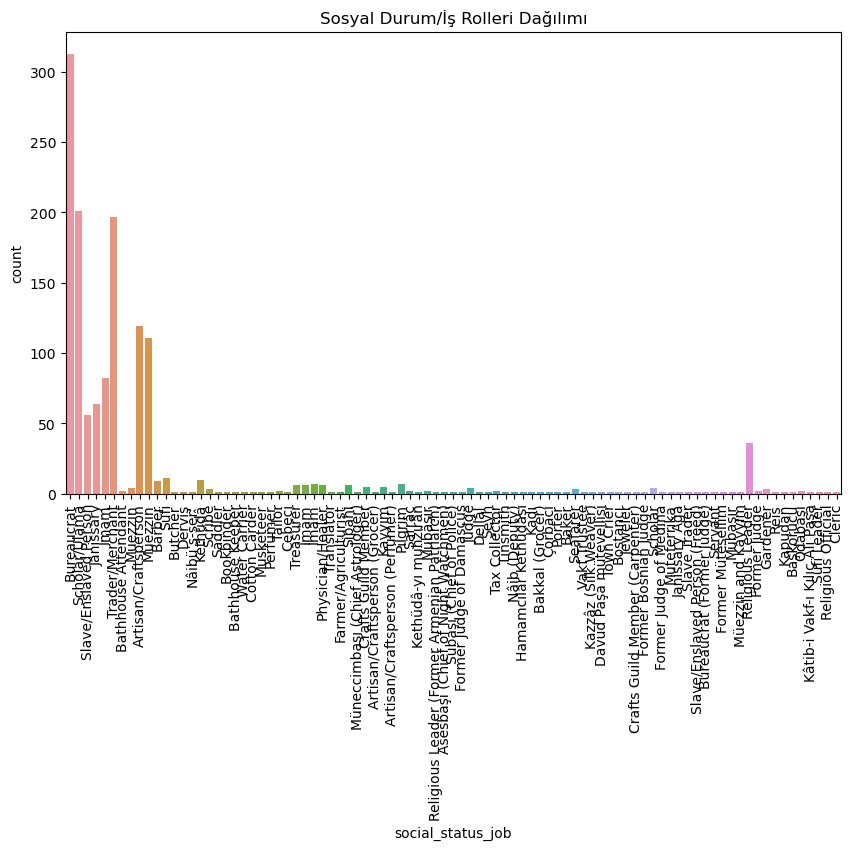

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=istanbul18, x='social_status_job')
plt.xticks(rotation=90)
plt.title('Sosyal Durum/İş Rolleri Dağılımı')
plt.show()

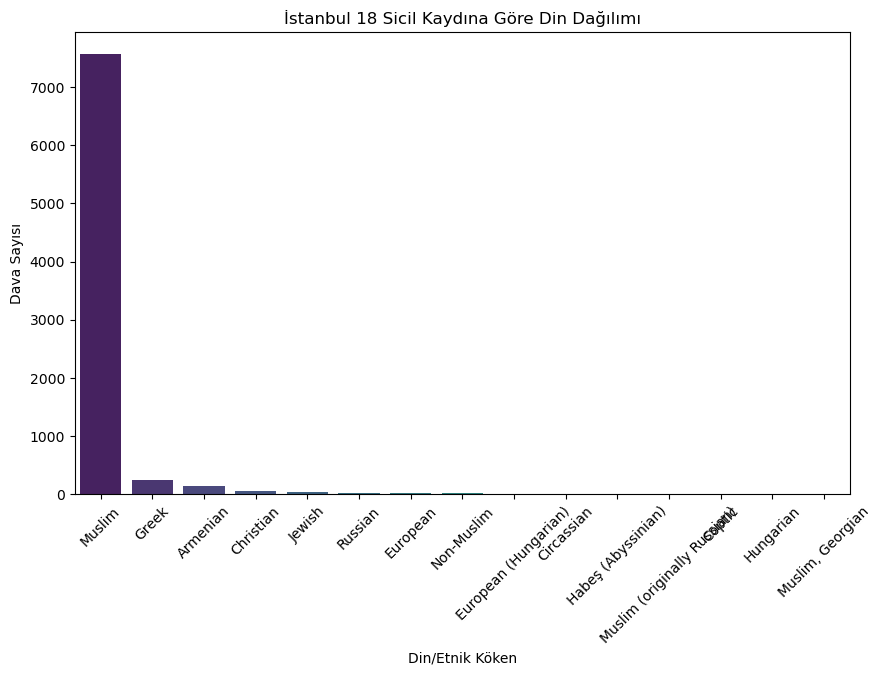

In [27]:
# Din dağılımı grafiği
plt.figure(figsize=(10, 6))
sns.barplot(x=religion_counts.index, y=religion_counts.values, palette='viridis')
plt.xlabel('Din/Etnik Köken')
plt.ylabel('Dava Sayısı')
plt.title('İstanbul 18 Sicil Kaydına Göre Din Dağılımı')
plt.xticks(rotation=45)
plt.show()


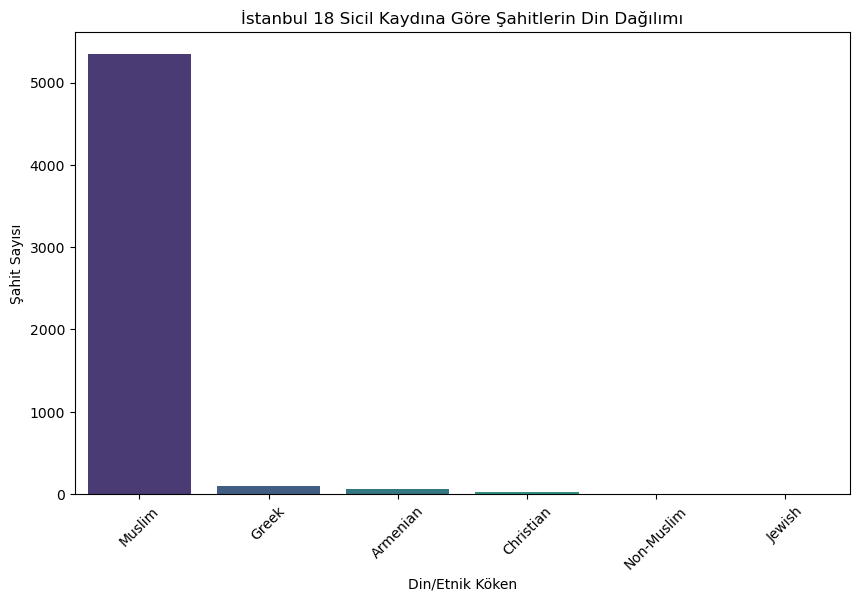

In [28]:
# Şahitleri filtreleyin
witnesses = istanbul18[istanbul18['role_in_case'] == 'Witness']
# Şahitlerin dini dağılımını hesaplayın
witness_religion_counts = witnesses['religion_ethnicity'].value_counts()
witness_religion_counts
# Jupyter Notebook'ta grafiklerin otomatik olarak gösterilmesi için
%matplotlib inline

# Şahitlerin dini dağılımı grafiği
plt.figure(figsize=(10, 6))
sns.barplot(x=witness_religion_counts.index, y=witness_religion_counts.values, palette='viridis')
plt.xlabel('Din/Etnik Köken')
plt.ylabel('Şahit Sayısı')
plt.title('İstanbul 18 Sicil Kaydına Göre Şahitlerin Din Dağılımı')
plt.xticks(rotation=45)
plt.show()

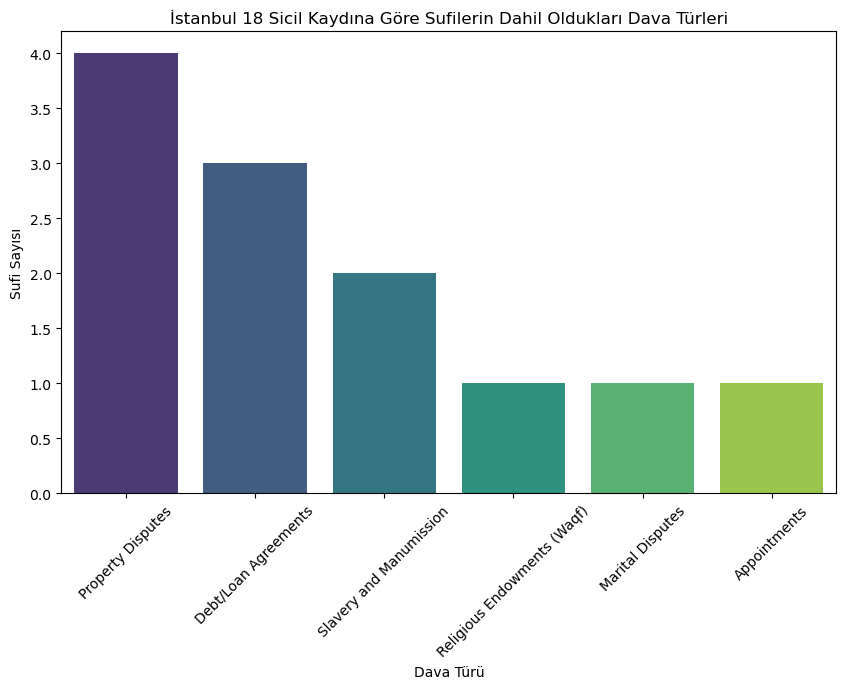

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sufi unvanlarını belirleyin
sufi_titles = ['Şeyh', 'Derviş', 'Dede', 'Baba', 'Mevlevi', 'Bektaşi', 'Nakşibendi', 'Halveti', 'Sufi', 'Sufi leader']

# Sufileri filtreleyin

sufis = istanbul18[istanbul18['social_status_job'].apply(lambda job: any(title in job for title in sufi_titles) if isinstance(job, str) else False)]

sufi_case_ids = sufis['case_unique_id'].unique()

if not sufis.empty:
    # Sufi unvanlarına sahip kişilerin bulunduğu davaları belirleyin
    sufi_case_ids = sufis['case_unique_id'].unique()

    # Bu davaların legal_case_type'larını çekin
    sufi_cases = istanbul18[istanbul18['case_unique_id'].isin(sufi_case_ids)]
    sufi_case_types = sufi_cases['legal_case_type'].value_counts()

    # Sufilerin dahil oldukları dava türleri grafiği
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sufi_case_types.index, y=sufi_case_types.values, palette='viridis')
    plt.xlabel('Dava Türü')
    plt.ylabel('Sufi Sayısı')
    plt.title('İstanbul 18 Sicil Kaydına Göre Sufilerin Dahil Oldukları Dava Türleri')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Sufi unvanlarına sahip kimse bulunamadı.")


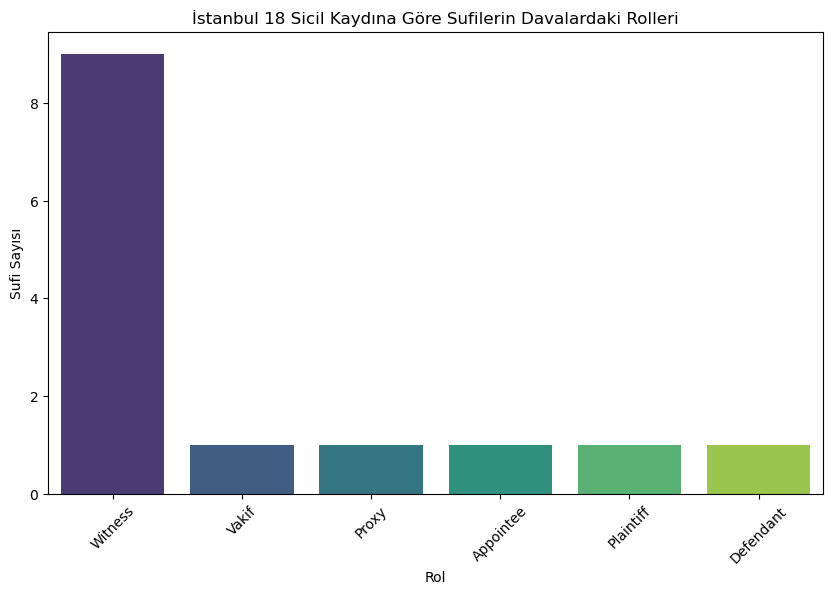

In [52]:
# Eğer sufiler dataframe'i boş değilse, devam et
if not sufis.empty:
    # Sufi davalarının rolleri
    sufi_roles = sufis['role_in_case'].value_counts()

    # Sufilerin davalardaki rolleri grafiği
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sufi_roles.index, y=sufi_roles.values, palette='viridis')
    plt.xlabel('Rol')
    plt.ylabel('Sufi Sayısı')
    plt.title('İstanbul 18 Sicil Kaydına Göre Sufilerin Davalardaki Rolleri')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Sufi unvanlarına sahip kimse bulunamadı.")

In [56]:
istanbul18.iloc[100:150]

,person_id,name,gender,religion_ethnicity,social_status_job,role_in_case,titles,date,calendar,place_name,place_type,legal_case_type,case_result,case_result_type,row_index,case_unique_id
100,İstanbul_i̇stanbul_18_hüküm no: 6_7,Mevlânâ Mustafa Efendi b. Abdülaziz,Man,Muslim,NaN,Investigator,"['Mevlânâ', 'Efendi']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
101,İstanbul_i̇stanbul_18_hüküm no: 6_8,el-Hâc Hüseyin Ağa b. Osman,Man,Muslim,NaN,Witness,"['el-Hâc', 'Ağa']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
102,İstanbul_i̇stanbul_18_hüküm no: 6_9,Hüseyin Beşe b. Hasan,Man,Muslim,NaN,Witness,['Beşe'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
103,İstanbul_i̇stanbul_18_hüküm no: 6_10,el-Hâc Yusuf b. Abdullah,Man,Muslim,NaN,Witness,['el-Hâc'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
104,İstanbul_i̇stanbul_18_hüküm no: 6_11,el-Hâc Ahmed b. Ramazan,Man,Muslim,Bathhouse Attendant,Witness,['el-Hâc'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
105,İstanbul_i̇stanbul_18_hüküm no: 6_12,Halil Beşe b. Mahmud,Man,Muslim,NaN,Witness,['Beşe'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
106,İstanbul_i̇stanbul_18_hüküm no: 6_13,el-Hâc Osman b. Murad,Man,Muslim,NaN,Witness,['el-Hâc'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
107,İstanbul_i̇stanbul_18_hüküm no: 6_14,Ali Bey b. İbrahim,Man,Muslim,NaN,Witness,['Bey'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
108,İstanbul_i̇stanbul_18_hüküm no: 6_15,Mehmed Beşe b. İbrahim,Man,Muslim,NaN,Witness,['Beşe'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6
109,İstanbul_i̇stanbul_18_hüküm no: 6_16,Mehmed Beşe b. Abdüllatîf,Man,Muslim,NaN,Witness,['Beşe'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,27139,i̇stanbul_18_hüküm no: 6


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2885075360.py, line 1)

In [61]:
istanbul_18_df = df_copy[(df_copy['court_title'] == 'İstanbul') & (df_copy['sicil_number'] == '18') & (df_copy['row_index'] == 27139)]

KeyError: 'row_index'